# Learning the electron density of water

### Install the relevant packages

1. `pip install metatensor`
1. `pip install chemiscope`
1. `pip install git+https://github.com/luthaf/rascaline.git@b2cedfe870541e6d037357db58de1901eb116c41`

In [ ]:
# TODO:
# - better model saving
# - initialize model with rascaline hypers

In [1]:
%load_ext autoreload
%autoreload 2

# Useful standard and scientific ML libraries
import os
import time
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
import torch

# M-Stack packages

import metatensor   # storage format for atomistic ML
import chemiscope  # interactive molecular visualization
import rascaline   # generating structural representations

from metatensor import Labels, TensorBlock, TensorMap
from rascaline.utils import clebsch_gordan

# Torch-based density leaning
from rholearn import io, data, descriptor, loss, models

top_dir = "/Users/joe.abbott/Documents/phd/code/rho/rho_learn/docs/example/h2o"
data_dir = os.path.join(top_dir, "data")

## Visualize and explore dataset: `chemiscope`

In [2]:
# Load all the frames in the dataset - 1000 water monomers in the gas phase
frames = ase.io.read(os.path.join(data_dir, "water_monomers_1k.xyz"), ":")

# DFT data is only computed for some of the frames - only hold onto these
all_idxs = np.arange(100)
frames = [frames[i] for i in all_idxs]
chemiscope.show(
    frames,
    properties={
        "Mean O-H bond length, Angstrom": [np.mean([f.get_distance(0, 1), f.get_distance(0, 2)]) for f in frames],
        "H-O-H angle, degrees": [f.get_angle(1, 0, 2) for f in frames],
    },
)

ChemiscopeWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["O", "H", "H"], "x": [0.0…

## Descriptor: $\lambda$-SOAP equivariant

In [3]:
rascal_settings =  {
    "hypers": {
        "cutoff": 3.0,  # Angstrom
        "max_radial": 6,  # Exclusive
        "max_angular": 5,  # Inclusive
        "atomic_gaussian_width": 0.3,
        "radial_basis": {"Gto": {}},
        "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
        "center_atom_weight": 1.0,
    },
    "compute": {},
}

cg_settings =  {
    "angular_cutoff": None,
    "angular_selection": [0, 1, 2, 3, 4, 5],
    "parity_selection": [+1],
}
calculator = rascaline.SphericalExpansion(**rascal_settings["hypers"])
nu_1_tensor = calculator.compute(frames, **rascal_settings["compute"])
nu_1_tensor = nu_1_tensor.keys_to_properties("species_neighbor")
lsoap = clebsch_gordan.lambda_soap_vector(nu_1_tensor, **cg_settings)

# Make a dir for the lambda-SOAP descriptors
if not os.path.exists(os.path.join(data_dir, "lsoap")):
    os.mkdir(os.path.join(data_dir, "lsoap"))

# Split into per-structure TensorMaps and save into separate directories.
# This is useful for batched training.
for A in all_idxs:
    if not os.path.exists(os.path.join(data_dir, f"lsoap/{A}")):
        os.mkdir(os.path.join(data_dir, f"lsoap/{A}"))
    lsoap_A = metatensor.slice(
        lsoap,
        "samples",
        labels=Labels(names="structure", values=np.array([A]).reshape(-1, 1)),
    )
    metatensor.save(os.path.join(data_dir, f"lsoap/{A}/lsoap.npz"), lsoap_A)

In [4]:
# Store the settings needed to build the descriptor. In module predictor.py,
# the function `build_descriptor` is used by the model, along with the
# `descriptor_kwargs` passed upon initialization, to generate a descriptor as
# part of the prediction pipeline. As the descriptor needs to be generated with
# the same settings as the training data, we store these settings in the model.
descriptor_kwargs = {
    "rascal_settings": rascal_settings,
    "cg_settings": cg_settings,
}

## Target: RI coefficients

In [5]:
# Load the basis set definition from the first DFT calculation
A = all_idxs[0]
calc_info = io.unpickle_dict(os.path.join(data_dir, f"dft/{A}/calc_info.pickle"))
basis_set = {"lmax": calc_info["lmax"], "nmax": calc_info["nmax"]}

# Check consistent basis set definition for all calculations
for idxs in all_idxs[1:]:
    # Load the info parsed from the AIMS calculation
    calc_info_tmp = io.unpickle_dict(os.path.join(data_dir, f"dft/{A}/calc_info.pickle"))
    # Check lmax
    for sym, val in calc_info_tmp["lmax"].items():
        assert basis_set["lmax"][sym] == val
    # Check nmax
    for (sym, l), val in calc_info_tmp["nmax"].items():
        assert basis_set["nmax"][(sym, l)] == val

# Define the settings need to ransform the raw prediction of the ML model 
target_kwargs = {
    "basis_set": basis_set,
}

## Create `dataset` and `dataloader`

In [6]:
train_idxs, test_idxs, val_idxs = data.group_idxs(
    all_idxs=all_idxs,
    n_groups=3,
    group_sizes=[50, 30, 20],
    shuffle=True,
    seed=10,
)

In [7]:
# Define some torch settings
torch_settings = {
    "dtype": torch.float64,
    "requires_grad": True,
    "device": torch.device(type="cpu"),
}

# Build the torch dataset
rho_data = data.RhoData(
    all_idxs=np.concatenate([train_idxs, test_idxs, val_idxs]),
    train_idxs=train_idxs,
    input_dir=os.path.join(data_dir, "lsoap"),
    output_dir=os.path.join(data_dir, "dft"),
    overlap_dir=os.path.join(data_dir, "dft"),
    keep_in_mem=True,
    # calc_out_train_inv_means=True,
    # calc_out_train_std_dev=True,
    filenames=["lsoap", "ri_coeffs", "ri_ovlp"],
    **torch_settings,
)

In [18]:
# Initialize model
model = models.RhoModel(
    model_type="linear",
    input=rho_data[0][1],
    output=rho_data[0][2],
    bias_invariants=True,
    # hidden_layer_widths=[8, 8],
    # activation_fn=torch.nn.Tanh(),
    descriptor_kwargs=descriptor_kwargs,
    target_kwargs=target_kwargs,
    **torch_settings
)

## Check the equivariance condition

### a) $\lambda$-SOAP descriptor

In [9]:
# Check equivariance of lambda-SOAP descriptor

# Generate Wigner-D matrices, initialized with random angles
wig = clebsch_gordan.WignerDReal(lmax=rascal_settings["hypers"]["max_angular"])
print("Random rotation angles (rad):", wig.angles)

# Apply an O(3) transformation to each frame 
frames_o3 = [clebsch_gordan.transform_frame_o3(frame, wig.angles) for frame in frames]
assert not np.allclose(frames[0].positions, frames_o3[0].positions)

# Generate lambda-SOAP for the transformed frames
lsoap_o3 = descriptor.descriptor_builder(frames_o3, **descriptor_kwargs)

# Apply the O(3) transformation to the TensorMap
lsoap_transformed = wig.transform_tensormap_o3(lsoap)

# Check for equivariance!
assert metatensor.equal_metadata(lsoap_transformed, lsoap_o3)
assert metatensor.allclose(lsoap_transformed, lsoap_o3)
print("O(3) EQUIVARIANT!")

Random rotation angles (rad): [0.08559972 0.11542214 3.30799449]
O(3) EQUIVARIANT!


### b) torch model (untrained)

In [10]:
# Make a prediction on both the original and O3-transformed lambda-SOAP
# descriptors
with torch.no_grad():
    pred = model(metatensor.to(lsoap, "torch", **torch_settings))
    pred_o3 = model(metatensor.to(lsoap_o3, "torch", **torch_settings))

# Transform the prediction made on the original (untransfored) lambda-SOAP
pred_transformed = wig.transform_tensormap_o3(pred)

# Check for equivariance!
assert metatensor.equal_metadata(pred_transformed, pred_o3)
assert metatensor.allclose(pred_transformed, pred_o3)
print("O(3) EQUIVARIANT!")

O(3) EQUIVARIANT!


/opt/miniforge3/envs/rho/lib/python3.10/site-packages/rholearn/models.py:292: UserWarning: one or more of input blocks at keys [LabelsEntry(spherical_harmonics_l=5, species_center=1)] is not  part of the keys of the model. The returned prediction will not contain this block.
  warnings.warn(


## Model training

In [11]:
# Construct dataloaders for training and testing
batch_size = 5
train_loader = data.RhoLoader(
    rho_data,
    idxs=train_idxs,
    get_overlaps=True,
    batch_size=batch_size,
)
test_loader = data.RhoLoader(
    rho_data,
    idxs=test_idxs,
    get_overlaps=True,
    batch_size=batch_size,
)

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = loss.L2Loss()

In [14]:
n_epochs = 5

# Start training loop
losses = {"train": [], "test": []}
for epoch in range(n_epochs):
    # Switch off metadata checking after the first epoch
    check_args = True if epoch == 0 else False

    # Iterate over train batches
    train_loss_epoch = 0
    for train_batch in train_loader:
        # Reset gradients
        optimizer.zero_grad()

        # Unpack train batch, respectively: structure idxs, lsoap, RI coeffs, RI
        # overlap matrices
        idxs_train, in_train, out_train, aux_train = train_batch

        # Make a prediction
        out_train_pred = model(in_train, check_args=check_args)

        # Evaluate training loss
        train_loss_batch = loss_fn(
            input=out_train_pred,
            target=out_train,
            overlap=aux_train,
            check_args=check_args,
        )

        # Calculate gradient and update parameters
        train_loss_batch.backward()
        optimizer.step()

        train_loss_epoch += train_loss_batch

    train_loss_epoch /= len(idxs_train)
    losses["train"].append(train_loss_epoch.detach().numpy())

    # Iterate over test batches: calculate the test loss
    with torch.no_grad():  # don't track gradients for test loss
        test_loss_epoch = 0
        for test_batch in test_loader:
            # Unpack test batch
            idxs_test, in_test, out_test, aux_test = test_batch

            # Make a prediction
            out_test_pred = model(in_test, check_args=check_args)

            # Evaluate test loss
            test_loss_batch = loss_fn(
                input=out_test_pred,
                target=out_test,
                overlap=aux_test,
                check_args=check_args,
            )
            test_loss_epoch += test_loss_batch

        test_loss_epoch /= len(idxs_test)
        losses["test"].append(test_loss_epoch.detach().numpy())

    print(
        f"Epoch {epoch} | Train loss: {train_loss_epoch} | Test loss: {test_loss_epoch}"
    )

Epoch 0 | Train loss: 21.300751532114614 | Test loss: 6.634450527046826
Epoch 1 | Train loss: 8.445384938387058 | Test loss: 2.484842689901609
Epoch 2 | Train loss: 3.0833488032978122 | Test loss: 1.2215482885903528
Epoch 3 | Train loss: 1.2315910336555458 | Test loss: 0.6732664011176005
Epoch 4 | Train loss: 0.701236442565251 | Test loss: 0.5017009563441024


Text(0, 0.5, 'Density loss per structure')

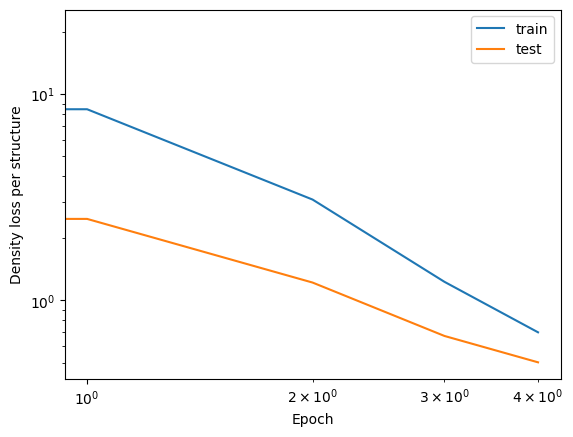

In [15]:
# Plot losses
fig, ax = plt.subplots()
for trace in ["train", "test"]:
    ax.loglog(np.arange(n_epochs), losses[trace], label=trace)

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Density loss per structure")

## Evaluate model performance on validation set



In [20]:
calc_info

{'aims': {'run_dir': '0',
  'run_id': 'A12E928E-235A-4E20-A47B-4B3B76757457',
  'version': '230629',
  'commit': '5b767ef01'},
 'scf': {'num_cycles': 19,
  'converged': True,
  'd_charge_density': [0.3125,
   0.2933,
   0.1793,
   0.1193,
   0.06321,
   0.05991,
   0.03983,
   0.03456,
   0.02939,
   0.01637,
   0.0003471,
   7.771e-05,
   2.265e-05,
   1.404e-06,
   2.418e-06,
   7.013e-08,
   3.732e-08,
   1.789e-08,
   2.224e-09],
  'd_tot_energy_eV': [0.1725,
   0.2183,
   1.021,
   0.9156,
   -0.0531,
   -0.005883,
   -0.02724,
   -0.02181,
   -0.06858,
   -0.09889,
   0.001542,
   0.001128,
   -0.0002347,
   -4.506e-05,
   2.9e-05,
   -7.289e-07,
   8.496e-07,
   -2.01e-07,
   1.261e-10]},
 'num_int_points': {'net': 49038, 'non-zero': 43948},
 'num_abfs': 418,
 'tot_energy_eV': -2078.591857368,
 'time': {'max(cpu_time)': 5.153, 'wall_clock(cpu1)': 5.369},
 'lmax': {'O': 5, 'H': 4},
 'nmax': {('O', 0): 9,
  ('O', 1): 10,
  ('O', 2): 9,
  ('O', 3): 8,
  ('O', 4): 6,
  ('O', 5): 4,


In [19]:
# Load the validation frames as ASE Atoms objects
out_val_frames = [frames[A] for A in val_idxs]

out_val_pred = model.predict(frames=out_val_frames)

/opt/miniforge3/envs/rho/lib/python3.10/site-packages/rholearn/models.py:306: UserWarning: one or more of input blocks at keys [LabelsEntry(spherical_harmonics_l=5, species_center=1)] is not  part of the keys of the model. The returned prediction will not contain this block.
  )


TypeError: target_builder() takes 1 positional argument but 2 were given

In [ ]:
# Build the validation dataloader
val_loader = data.RhoLoader(
    rho_data,
    idxs=val_idxs,
    get_overlaps=False,
    batch_size=None,
)
idxs_val, in_val, out_val = next(iter(val_loader))

# Make a prediction
out_val_pred = model.predict(input=in_val)

assert metatensor.equal_metadata(out_val_pred, out_val)

# Split the prediction into separate TensorMaps for each structure
out_val_pred_list = []
for A in idxs_val:
    out_val_pred_list.append(
        metatensor.slice(
            out_val_pred,
            "samples",
            labels=Labels(names="structure", values=np.array(A).reshape(-1, 1)),
        )
    )

for i, tensor in zip(idxs_val, out_val_pred_list):
    assert i == metatensor.unique_metadata(tensor, "samples", "structure").values[0]

In [ ]:
# Load the validation frames as ASE Atoms objects
out_val_frames = [frames[A] for A in idxs_val]

# Convert the TensorMaps to numpy arrays
out_val_pred_np = [
    convert.coeff_vector_tensormap_to_ndarray(frame, tensor, )
]

In [ ]:
for tensor in out_val_pred:
    print(metatensor.unique_metadata(tensor, "samples", "structure"))

## Make a prediction on unseen structure

In [ ]:
# Load some structures we don't have a DFT reference for
unseen_structures = ase.io.read(
    os.path.join(data_dir, "water_monomers_1k.xyz"), f"{n_frames}:{n_frames + 5}"
)

# Make an end-to-end prediction: XYZ coordinates ---> RI coefficients
model.predict(frames=unseen_structures)

In [ ]:
lsoap.keys.names

In [ ]:
# Visualize the predicted density
v = py3Dmol.view()
v.addModelsAsFrames(open(os.path.join(plot_dir, "out_val_pred.cube"), "r").read(), "cube")
v.setStyle({"stick": {}})
v.addVolumetricData(
    open(os.path.join(plot_dir, "out_val_pred.cube"), "r").read(),
    "cube",
    {"isoval": 0.05, "color": "blue", "opacity": 0.8},
)
v.show()


# Visualize the delta density